# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="data/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [2]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


### Exercise 1:

#### 1.1

Provide summary statistics for all the variables in the dataset. What can you say about the average income of the population throughout the years? What percentage of the population saw a decrease in income from 1974 to 1975? What do you think happened in 1975?

**Answer.**

In [3]:
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


As we can see from the table above, the average income fluctuated throughout the years, exhibiting a sharp decrease from 1974 to 1975, but rising again in 1978. In fact, we can see that the mean real income during 1978 is the highest value of all three periods.

To determine the percentage of the population that exhibited a decrease in its income, we identify the observations where `re75` is lower than `re74`:

In [4]:
lalonde_df[lalonde_df['re75'] < lalonde_df['re74']].shape[0]/lalonde_df.shape[0]

0.46416938110749184

So, nearly half of the people in the dataset (46,4%) exhibited a reduction in its income. This could be explained by several factors. For instance, during the 70s the USA economy was experiencing a decline in its gross domestic product (GDP), so maybe during 1975 the people in the dataset loose their jobs.

-------

#### 1.2 
    
What percentage of the workers in our dataset are in the treatment group? Find the difference in means and medians of earnings between the control group and the treatment group. Is the difference of means statistically significant?

**Note:** Remember that the *treatment and control groups* correspond to the sets of workers that were enrolled and not enrolled in the job training program, respectively. We can check if a worker is part of the treatment group by simply checking the value of the  `treat` column.

**Answer.**

The percentage of workers in the treatment group is approximately 30%: 

In [5]:
lalonde_df[lalonde_df['treat'] == 1].shape[0]/lalonde_df.shape[0]

0.30130293159609123

When we look at the mean difference in income between those treated (`treat==1`) and not treated (`treat==0`) we see that in all the years of the study the non-treated exhibited an income superior than the other group. However, during 1978 the gap between both groups was less than in previous years:

In [6]:
lalonde_df.groupby('treat')[['re74','re75','re78']].mean()

,re74,re75,re78
treat,,,
0,5619.236506,2466.484443,6984.169742
1,2095.573689,1532.055314,6349.143530


Similar results are found when we calculate the median difference, although we can clearly see the prevalence of no income for the treated group during 1974 and 1975:

In [7]:
lalonde_df.groupby('treat')[['re74','re75','re78']].median()

,re74,re75,re78
treat,,,
0,2547.047,1086.726,4975.505
1,0.000,0.000,4232.309


Finally, we could test if the observed differences in mean income are statistically significant. For this, we conduct a t-test for each year between the two groups. We could see that during 1974 and 1975 the $p$-value of the test is less than 5% and even lower than 1%, rejecting the null-hypothesis. That is, we could say that the differences in mean income between the two groups are statistically significant:

In [8]:
scipy.stats.ttest_ind(lalonde_df[lalonde_df['treat'] == 0]['re74'],lalonde_df[lalonde_df['treat'] == 1]['re74'])[1]

3.464585257757616e-10

In [9]:
scipy.stats.ttest_ind(lalonde_df[lalonde_df['treat'] == 0]['re75'],lalonde_df[lalonde_df['treat'] == 1]['re75'])[1]

0.0012234443948498416

On the other hand, for 1978 the $p$-value is way bigger than the 5% threshold, indicating that we cannot reject the null-hypothesis, so, we cannot say that the difference in means is statistically significant:

In [10]:
scipy.stats.ttest_ind(lalonde_df[lalonde_df['treat'] == 0]['re78'],lalonde_df[lalonde_df['treat'] == 1]['re78'])[1]

0.3342496685909654

-------

#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer.**

Given that the variable of interest is `re78`, if anything, we could say that the treatment had a **positive** impact in the earnings of those that were selected in the training program between 1975 and 1978, not a negative impact. However, we should bear in mind that there could be other factors that drive this result and we should not be too quick to talk about **causation** with just and statistical difference in means between two groups.

-------

Before we start our exploration on causality, let's perform some simple setup:

1. We seperate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [11]:
#First, let's reset the indexes
cleaned_df=lalonde_df.reset_index().drop(['index'],axis=1)
#Create seperate structure for data and target 
treatment = cleaned_df['treat']
rev78 = cleaned_df['re78']
cleaned_df = cleaned_df.drop(['treat', 're78'], axis=1)

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. That is, we would like to check whether the treatment and control groups have similar distributions of ages. We can look at **Standardized Mean Differences (SMD)**, which is calculated as follows: let $(\bar{x}_t,s_t^2)$ and $(\bar{x}_c, s_c^2)$ denote the mean and variance corresponding to the treatment and control groups of the particular feature of interest. Then, the SMD is defined as the value:

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$

We can calculate the SMD for every feature. If our calculated SMD is 1, then that means there is a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: We say that the feature is balanced. In general, for a **randomized trial**, the SMD for all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD falls in this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer.**

In [12]:
balance = []

for var in list(cleaned_df.columns):
    #Variable selection:
    treat_var   = lalonde_df[lalonde_df['treat']==1][var]
    control_var = lalonde_df[lalonde_df['treat']==0][var]
    
    #Means and variances:
    mean_treat    = treat_var.mean()
    mean_control  = control_var.mean()
    sigma_treat   = treat_var.std()**2
    sigma_control = control_var.std()**2
    
    # Standarized mean differences:    
    smd = (mean_treat - mean_control)/((sigma_treat+sigma_control)/2)**(1/2)
    
    #Append the results to the list:
    balance.append([var,round(smd,3)])
    
balance

[['age', -0.242],
 ['educ', 0.045],
 ['black', 1.668],
 ['hispan', -0.277],
 ['married', -0.719],
 ['nodegree', 0.235],
 ['re74', -0.596],
 ['re75', -0.287]]

From the results we can see that there are only two features that exhibit an imbalance. Those are `black` and `nodegree`. These present a SMD of 1.67 and 0.23 respectively, indicating that both are seriously imbalanced. 

-------

#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer.**

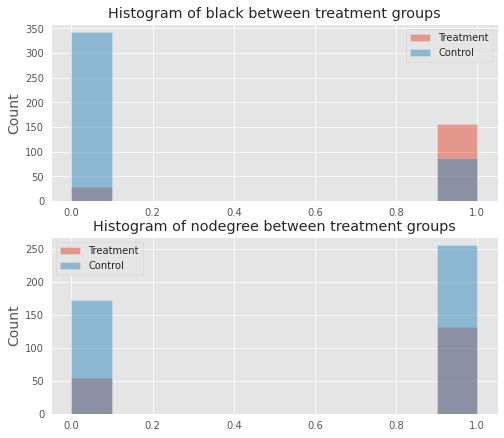

In [13]:
plt.figure(figsize=(8,15))

for i,var in enumerate(['black','nodegree']):
    plt.subplot(4,1,i+1)
    plt.hist(lalonde_df[lalonde_df['treat']==1][var], alpha=0.5, label="Treatment")
    plt.hist(lalonde_df[lalonde_df['treat']==0][var], alpha=0.5, label="Control")
    plt.ylabel("Count", size=14)
    plt.title("Histogram of "+var+" between treatment groups")
    if var=='black':
        plt.legend(loc='upper right')
    else:
        plt.legend(loc='upper left')

-------

## Propensity score matching using logistic regression 

In order to balance the covariates of the control and treatment groups, we will use **matching**. Remember that we used matching in Case 7.5 to balance a population of prisoners to evaluate the effectiveness of a program aiming to reduce recidivism. Thus, the situation here is quite similar.
    
In Case 7.5 we used the *Euclidean distance* on the sample data to create the matching: for each individual of the treatment group, we would find the closest (in Euclidean distance) individual in the control group to match on. Although this method is attractive in general, we may have instances in which the balancing of some particular feature is more important than others. Say the employment program was aiming to create a positive impact within the Hispanic community and a higher proportion of individuals in the treatment group were Hispanic. The Euclidean distance would not take this into account, and we may end up comparing the effect of the treatment between Hispanics and other ethnicities.

We can alleviate this issue by using a metric that takes into account the characteristics of the treatment group. In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affect our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 3:

#### 3.1 

Estimate the propensity scores using a logistic regression. Build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. How would you interpret the predicted values output by the model? 

**Answer.**

In [14]:
model_pscore = smf.logit(formula='treat ~ age + educ + black + hispan + married + nodegree + re74 + re75',data=lalonde_df).fit()
model_pscore.summary()

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sun, 01 Aug 2021   Pseudo R-squ.:                  0.3508
Time:                        19:01:21   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

Since the results of the model come from a logistic regression, the coefficients are the logarithm of odds and have to be interpreted in that way. Each estimated coefficient is the expected change in the log odds of being in the treatment group for a unit increase in the corresponding predictor variable, holding the other predictor variables constant.

For instance, one unit increase in `age` would increase the log odds of being in the treated group by 0.0158. Nevertheless, this variable is not statistically significant, which could lead to a bad interpretation of the results. On the contrary, we could say that being black (`black==1`) increases the log odds of being in the treatment group by almost 3.

-------

#### 3.2

Use `.predict()`  to obtain the propensity scores of individuals in our dataset. Save the the results with the name `pscore_logit` (these will be used later). In addition, make plots which show the distribution for both the treatment and control groups of propensity scores.

**Answer.**

In [15]:
pscore_logit = model_pscore.predict()

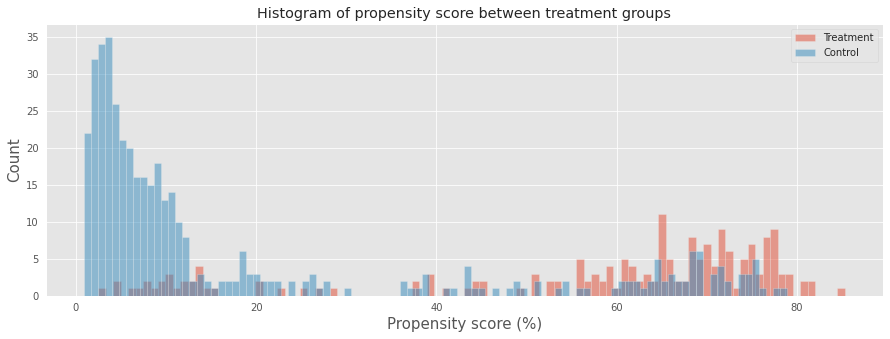

In [16]:
plt.figure(figsize=(15,5))
pscore_by_treat = pd.DataFrame(pscore_logit,treatment,columns=['prop_score']).reset_index()
plt.hist(pscore_by_treat[pscore_by_treat['treat']==1]['prop_score']*100,bins=100,alpha=0.5,label='Treatment')
plt.hist(pscore_by_treat[pscore_by_treat['treat']==0]['prop_score']*100,bins=100,alpha=0.5,label='Control')
plt.xlabel("Propensity score (%)", size=15)
plt.ylabel("Count", size=15)
plt.title("Histogram of propensity score between treatment groups")
plt.legend();

-------

### Matching using $k$-nearest neighbors

We are going to match each treated subject with a control subject using nearest neighbors matching on the estimated propensity score. Here, we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**. This algorithm is quite similar to the one we used in Case 7.5. However, instead of finding the single control individual with the closest propensity score, it finds the $k$ control individuals with the closest propensity scores. The use of $k>1$ is handy for classification purposes: if each individual lies in a category, we can classify a new individual by finding its $k$ nearest neighbors and use the most common category of its neighbors as the selected category for the new individual. 

### Exercise 4

In this exercise, we will use the `sklearn.neighbors` function [`NearestNeighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors) to find, for each subject in the treatment group, the $k=5$ subjects in the control group with the closest propensity scores.

#### 4.1

Separate the propensity scores `pscore_logit` found in Exercise 3 for treatment and control groups. Call these `treat_pscores` and `control_pscores` respectively. Use the `control_pscores` to train a $k$-NN algorithm with $k=5$.

**Hint:** Load the model using `knn = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')`. You may want to reshape the control scores using `control_pscores.reshape(-1,1)`.

**Answer.**

In [17]:
treat_pscores   = pscore_by_treat[pscore_by_treat['treat']==1]
control_pscores = pscore_by_treat[pscore_by_treat['treat']==0]
knn             = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')

In [18]:
knn.fit(control_pscores.to_numpy())

NearestNeighbors(metric='euclidean')

-------

#### 4.2

Find the indices of the five nearest neighbors using the method `.kneighbors()` applied to `treat_pscores`. 

**Answer.**

In [19]:
knn.kneighbors(treat_pscores.to_numpy())

(array([[1.00000002, 1.00000455, 1.0000085 , 1.0000085 , 1.00002812],
        [1.00000015, 1.00000208, 1.0000356 , 1.00006916, 1.00008781],
        [1.00000015, 1.00000485, 1.00000711, 1.00000882, 1.00001171],
        [1.00000335, 1.00007429, 1.00008254, 1.00025711, 1.00029907],
        [1.00000594, 1.00001229, 1.00002945, 1.00003331, 1.00004276],
        [1.00001564, 1.00001809, 1.00002231, 1.000026  , 1.00002789],
        [1.00000185, 1.0000054 , 1.0000075 , 1.00000827, 1.00001596],
        [1.00000015, 1.00005844, 1.00032733, 1.00065055, 1.00071635],
        [1.00000043, 1.00004357, 1.00012329, 1.00034295, 1.00039117],
        [1.        , 1.00000001, 1.00000027, 1.00000037, 1.0000004 ],
        [1.00000024, 1.00000025, 1.00000333, 1.00000403, 1.00000567],
        [1.        , 1.00000009, 1.0000002 , 1.00000059, 1.00000411],
        [1.00000003, 1.00000168, 1.00000179, 1.00000647, 1.00000647],
        [1.00000033, 1.00000748, 1.00013453, 1.00019397, 1.00026272],
        [1.00000291,

To retrieve only the indexes of the the observations in the control group that matches our treatment group it suffices to add the `return_distance=False` argument to the function.

-------

#### 4.3

Match the treatment and control groups using the closest of the five neighbors found above. Your output should be a pair of `DataFrames`, each with $185$ rows from the `lalonde_df`. The first should correspond to the treatment group and the second should correspond to the matched control group.

**Answer.**

We could begin by creating the first `DataFrame` which corresponds to the data from the treatment group, with its corresponding propensity score. We'll label this as `treatdf`:

In [20]:
lalonde_df_pscore = pd.concat([lalonde_df.reset_index(drop=True),pd.DataFrame(pscore_logit,columns=['prop_score'])],axis=1)
treat_df          = lalonde_df_pscore[lalonde_df_pscore['treat']==1]
treat_df

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
0,1,37,11,1,0,1,1,0.00,0.00,9930.0460,0.638770
1,1,22,9,0,1,0,1,0.00,0.00,3595.8940,0.224634
2,1,30,12,1,0,0,0,0.00,0.00,24909.4500,0.678244
3,1,27,11,1,0,0,1,0.00,0.00,7506.1460,0.776324
4,1,33,8,1,0,0,1,0.00,0.00,289.7899,0.701639
...,...,...,...,...,...,...,...,...,...,...,...
180,1,33,12,1,0,1,0,20279.95,10941.35,15952.6000,0.287016
181,1,25,14,1,0,1,0,35040.07,11536.57,36646.9500,0.149168
182,1,35,9,1,0,1,1,13602.43,13830.64,12803.9700,0.494681
183,1,35,8,1,0,1,1,13732.07,17976.15,3786.6280,0.507418


Now, to create the second `DataFrame`, which corresponds to the matched control group, we'll create a for loop that retrieves the first neighbor for each of the treated observations (output from the previous exercise). We could create a list of indexes that then we're going to call from the `lalonde_df_pscore` that we have just created.

In [21]:
indexes = []

for i in range(0,len(knn.kneighbors(treat_pscores.to_numpy())[1])):
    indexes.append(knn.kneighbors(treat_pscores.to_numpy())[1][i][0])

#Show the first 5 elements of the list:
indexes[:5]

[68, 110, 369, 225, 139]

To get a sense on how closely related these two observations are we could see the propensity score for the first treated person, and the propensity score of its corresponding nearest neighbor. As we can see, the `prop_score` is practically the same for both of them:

In [22]:
lalonde_df_pscore[lalonde_df_pscore['treat']==1].iloc[0]

treat            1.00000
age             37.00000
educ            11.00000
black            1.00000
hispan           0.00000
married          1.00000
nodegree         1.00000
re74             0.00000
re75             0.00000
re78          9930.04600
prop_score       0.63877
Name: 0, dtype: float64

In [23]:
lalonde_df_pscore[lalonde_df_pscore['treat']==0].iloc[68]

treat             0.000000
age              30.000000
educ             17.000000
black             1.000000
hispan            0.000000
married           0.000000
nodegree          0.000000
re74          17827.370000
re75           5546.419000
re78          14421.130000
prop_score        0.638554
Name: 253, dtype: float64

Finally, we create the structure of interest, which we'll call `control_df`:

In [24]:
control_df = lalonde_df_pscore[lalonde_df_pscore['treat']==0].iloc[indexes]
control_df

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
253,0,30,17,1,0,0,0,17827.37000,5546.4190,14421.1300,0.638554
295,0,51,11,0,0,0,1,48.98167,3813.3870,1525.0140,0.224079
554,0,16,9,1,0,0,1,0.00000,0.0000,2158.9590,0.678789
410,0,39,10,1,0,0,1,844.44400,889.7903,701.9201,0.778912
324,0,19,9,1,0,0,1,1079.55600,2873.4680,14344.2900,0.705085
...,...,...,...,...,...,...,...,...,...,...,...
423,0,18,11,0,1,0,1,0.00000,630.1935,0.0000,0.279756
260,0,26,12,0,1,0,0,7968.33800,5109.5810,4181.9660,0.154729
564,0,34,12,1,0,1,0,0.00000,0.0000,18716.8800,0.494177
208,0,47,8,1,0,1,1,9275.16900,8543.4190,0.0000,0.508688


-------

### Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyze the causality effect of the treatment.

### Exercise 5

Make a plot which shows the histograms of propensity scores for the control and treatment groups after matching. Compare your results with the plot in Exercise 3.2.

**Answer.**

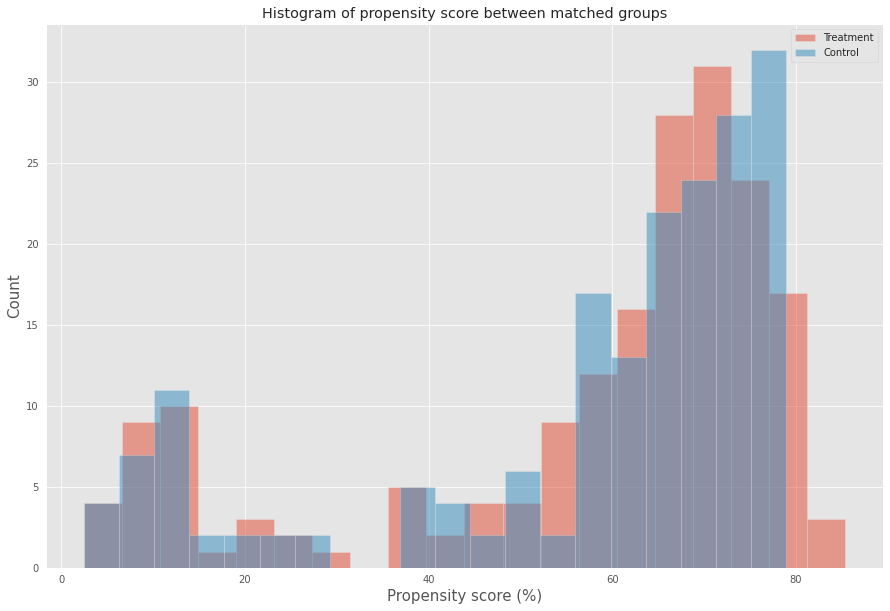

In [25]:
plt.figure(figsize=(15,10))
plt.hist(treat_df['prop_score']*100,bins=20,alpha=0.5,label='Treatment')
plt.hist(control_df['prop_score']*100,bins=20,alpha=0.5,label='Control')
plt.title('Histogram of propensity score between matched groups')
plt.xlabel("Propensity score (%)", size=15)
plt.ylabel("Count", size=15)
plt.legend();

From the histogram we could see that, contrary to the plot in ex. 3.2, the distribution of `prop_score` after matching is quite similar for both treatment and control groups. This makes total sense since the KNN algorithm tries to identify which of the treated observations are more closely related to the non-treated, given a set of characteristics.

-------

### Exercise 6

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer.**

In [26]:
new_balance  = []
vars_to_look = ['age','educ','black','hispan','married','nodegree','re74','re75']

for var in vars_to_look:
    #ASMD Numerator:
    mean_treat_after   = treat_df[var].mean()
    mean_control_after = control_df[var].mean()
    
    #ASMD Denominator:
    sigma_treat_before   = lalonde_df_pscore[lalonde_df_pscore['treat']==1][var].std()**2
    sigma_control_before = lalonde_df_pscore[lalonde_df_pscore['treat']==0][var].std()**2
    
    # Standarized mean differences:    
    asmd = (mean_treat_after - mean_control_after)/((sigma_treat_before+sigma_control_before)/2)**(1/2)
    
    #Append the results to the list:
    new_balance.append([var,round(asmd,3)])
    
new_balance

[['age', 0.187],
 ['educ', -0.013],
 ['black', 0.014],
 ['hispan', -0.018],
 ['married', 0.132],
 ['nodegree', 0.011],
 ['re74', -0.041],
 ['re75', 0.009]]

As we could expect, the two variables that were previously imbalanced (`black` and `nodegree`) are now balanced after matching. What is also interesting to note is that `age` and `married`, although not imbalanced, exhibit a value near 0.2, which then could classify them as imbalanced.

-------

### Exercise 7

Estimate the average effect of treatment on wages (`re78`) after matching. What do you conclude?

**Answer.**

In order to compare the results after matching we should only focus on `treat_df` and `control_df`. As we can see, the mean value on wages in 1978 for the treated group is 6,349 as we have seen in a previous exercise. However, what is surprising is that the mean wage for the control group is 4,574, **lower than the 6,984 found before!!!**. In this sense, we could see that out initial results were underestimated because of the imbalance of the sample. 

In [35]:
pd.DataFrame(pd.concat([treat_df,control_df]).groupby('treat')['re78'].mean())

,re78
treat,
0,4574.682159
1,6349.143530


-------

## Propensity score matching using decision trees and random forests

### Exercise 8

To validate our propensity score calculations, let's try calculating them using other models such as decision trees and random forests.

#### 8.1

Build a decision tree regressor where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. Use the `sklearn.tree` function `DecisionTreeRegressor(max_depth=4)` and call the new propensity scores `pscore_tree`.

**Answer.**

In [28]:
covariates  = ['age','educ','black','hispan','married','nodegree','re74','re75']
dec_tree    = tree.DecisionTreeRegressor(max_depth=4).fit(lalonde_df[covariates], lalonde_df['treat'])
pscore_tree = dec_tree.predict(lalonde_df[covariates])

-------

#### 8.2

Plot the decision tree regressor using the code

```
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dt,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')
```

Replace `dt` with the name of the model created in Exercise 8.1. Use the plot to estimate the probability that a 24 year old, single, uneducated Hispanic individual that earned $\$20000$ in 1974 was enrolled in the employment program. Do the same with a black man with the same characteristics. (Assume that there were no black Hispanics in the study.)

**Answer.**

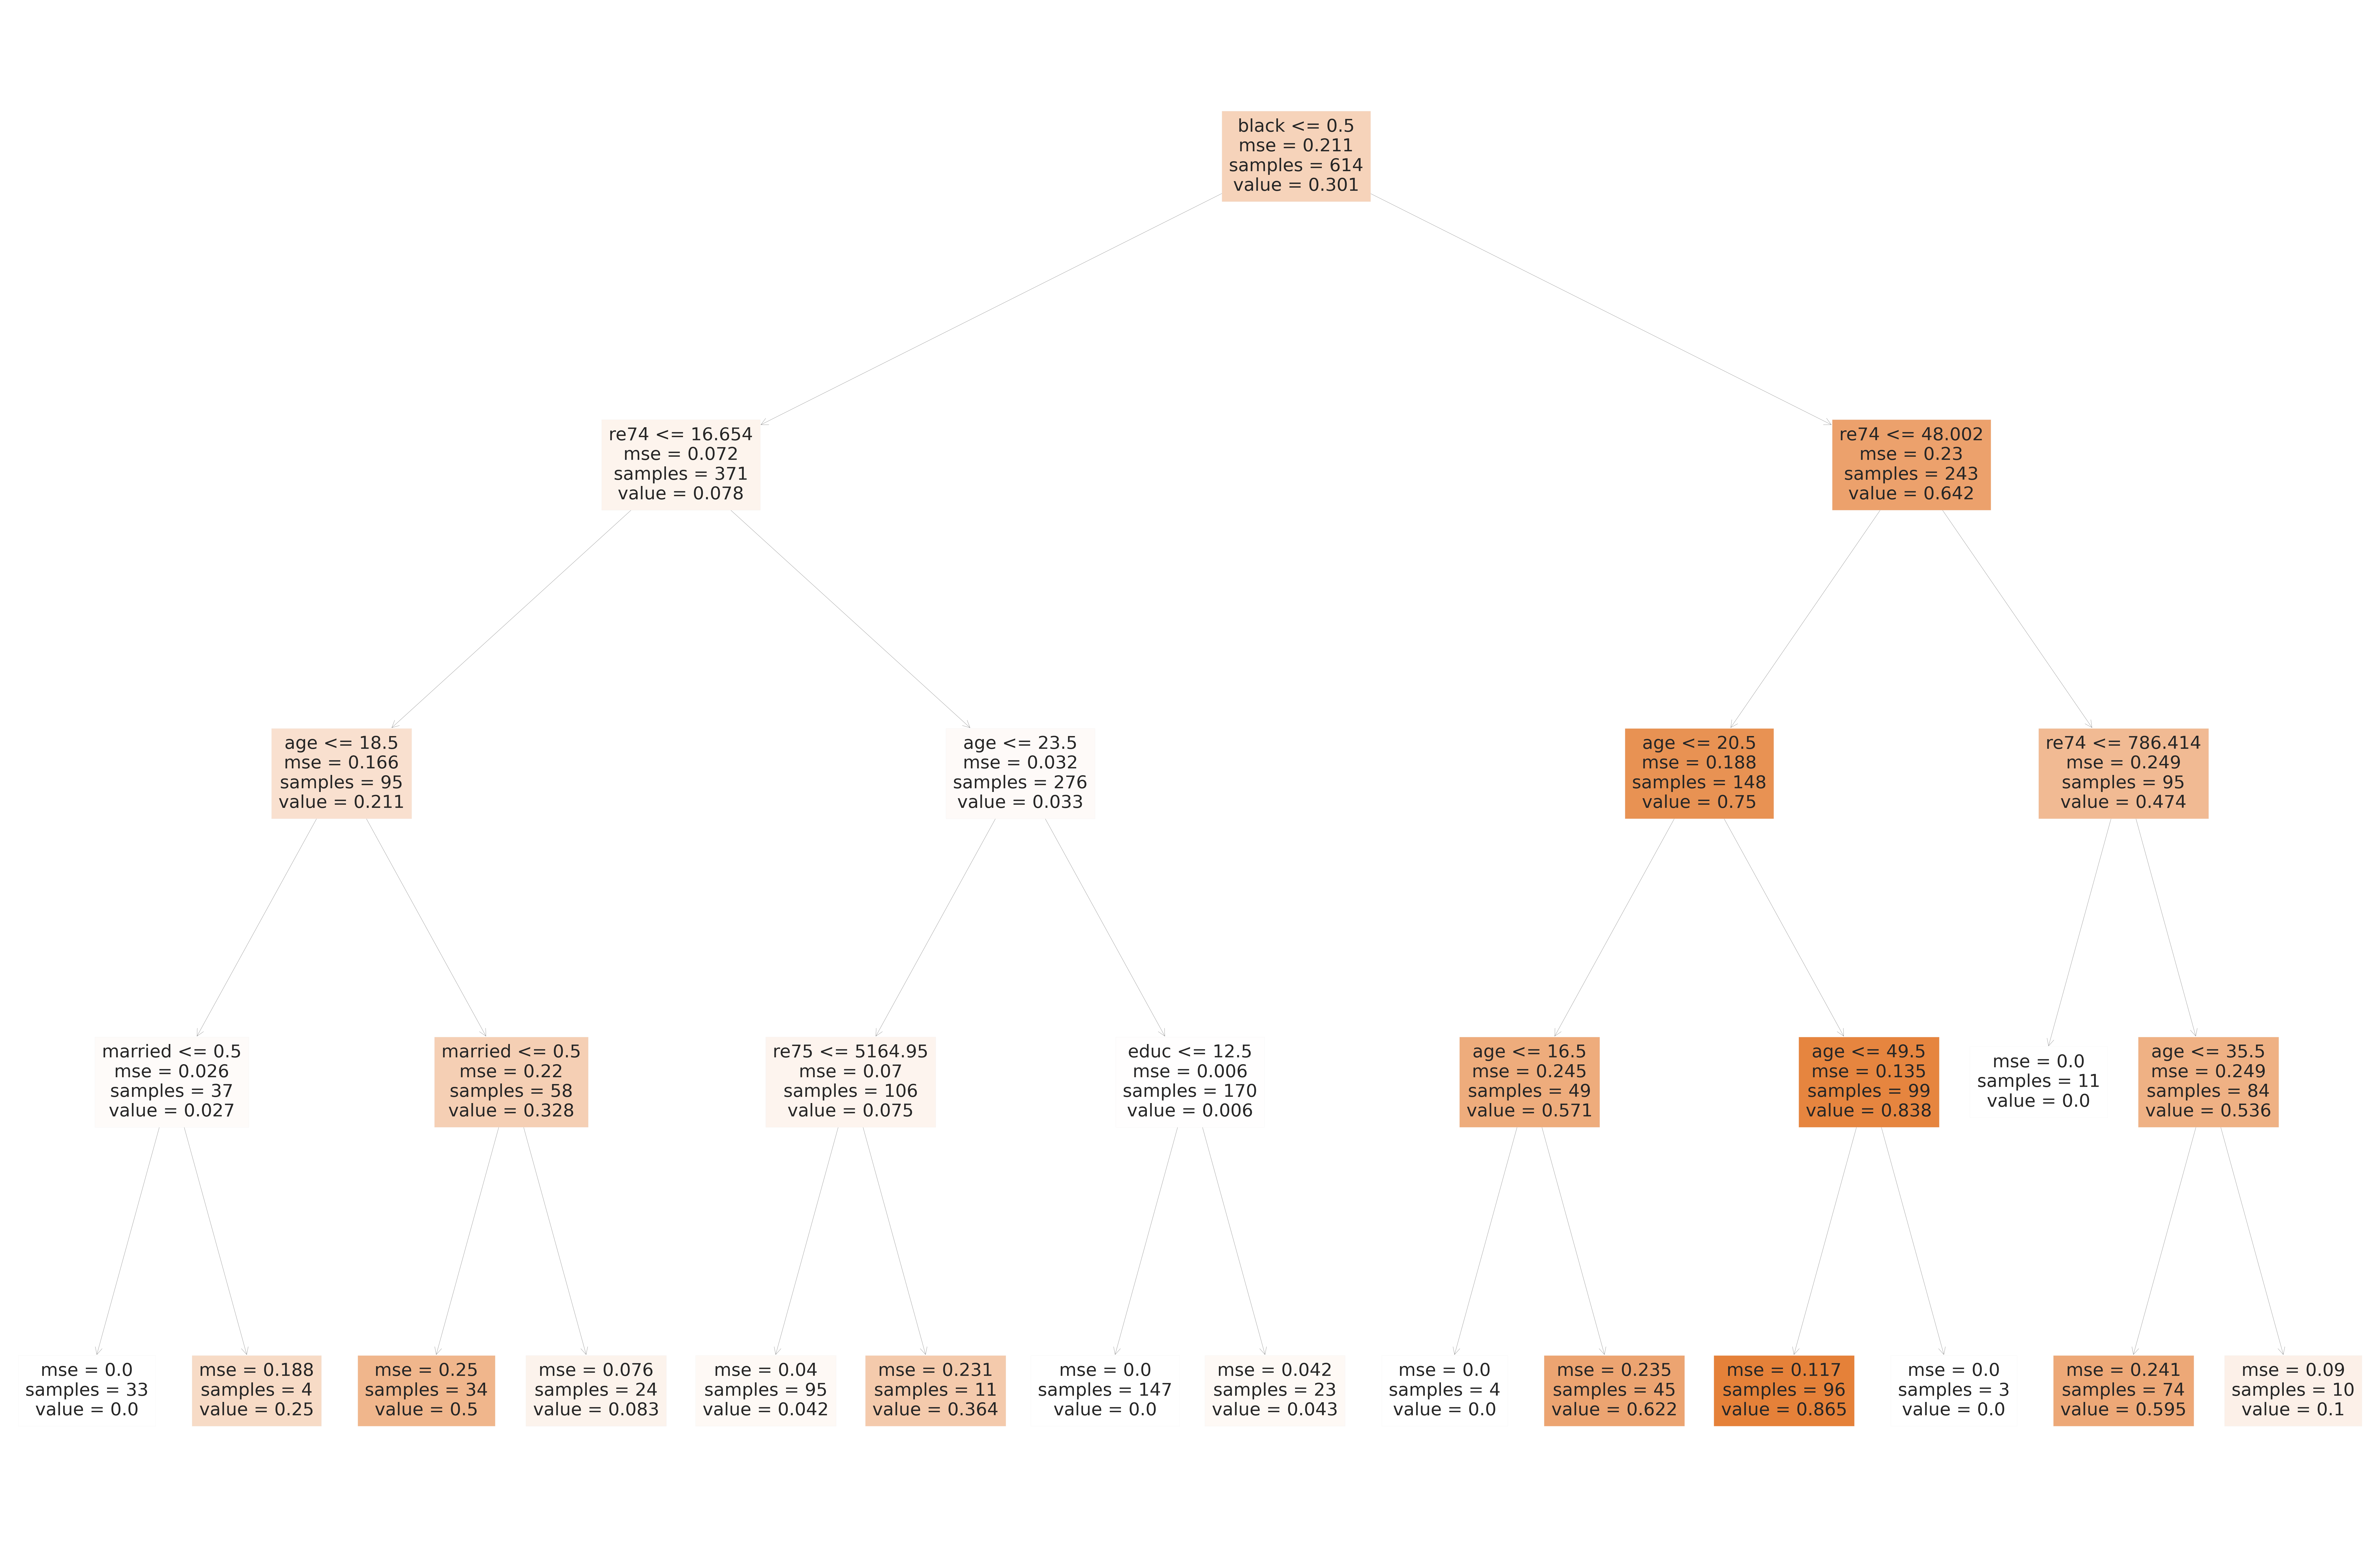

In [29]:
fig = plt.gcf()
fig.set_size_inches(150, 100)
tree.plot_tree(dec_tree,filled=True,feature_names=cleaned_df.columns)
fig.savefig('tree.png')

The first case lead us to the seventh leaf node of the tree from left to right. Since the size of the sample of people with the characteristics mentioned is 147, then the probability of being in the treatment group should be $(147/614)*100 = 23,9\%$. However, since the `value` represents the proportion of people in the treatment group, we could see that despite the $23,9\%$ probability, there were actually no people with those characteristics in the treated group.

On the other hand, when we consider a person with those characteristics but also being a black person, the result lead us to the fourth leaf node, from right to left. We could see that the probability in this case would be $(96/614)*100 = 15,6\%$, but the actual proportion of people with those characteristics in the treatment group was $86,5\%$.

-------

#### 8.3

Estimate the propensity scores now by using random forests. For the model, use the `sklearn.ensemble` function `RandomForestClassifier` with parameters `n_estimators=100, max_depth=4, random_state=42`. Then, use the method `predict_proba` to extract the propensity scores. Name the scores `pscore_forest`.

**Answer.**

In [30]:
clf_rf = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
clf_rf.fit(lalonde_df[covariates],lalonde_df['treat'])
pscore_forest = clf_rf.predict_proba(lalonde_df[covariates])

In [31]:
pscore_forest #Returns an array with the probabilities of each class. First column is for 0, second for 1.

array([[0.36670829, 0.63329171],
       [0.61015369, 0.38984631],
       [0.26464797, 0.73535203],
       ...,
       [0.75290709, 0.24709291],
       [0.40824479, 0.59175521],
       [0.81436528, 0.18563472]])

-------

#### 8.4

Make a plot with the three ROC curves corresponding to the logistic regression, decision tree, and random forest classifiers used to compute the propensity scores. What is the AUC of each model? Which model *seems* to do the best job?

**Answer.**

In [32]:
from sklearn.metrics import roc_curve, auc

#ROC and AUC from logit:
roc_logit = roc_curve(lalonde_df['treat'], pscore_logit)
auc_logit = auc(roc_logit[0],roc_logit[1])

#ROC and AUC from decision tree:
roc_tree = roc_curve(lalonde_df['treat'], pscore_tree)
auc_tree = auc(roc_tree[0],roc_tree[1])

#ROC and AUC from random forest:
roc_forest = roc_curve(lalonde_df['treat'],pscore_forest[:,1])
auc_forest = auc(roc_forest[0],roc_forest[1])

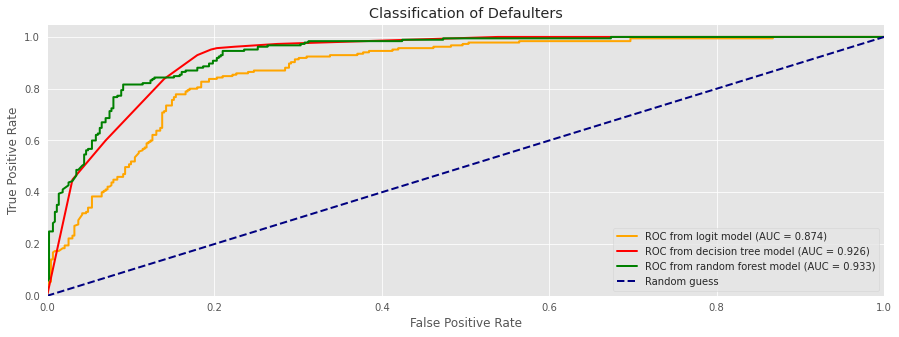

In [33]:
plt.figure(figsize=(15,5))
line_width = 2
plt.plot(roc_logit[0], roc_logit[1], color='orange', lw=line_width,
         label=f"ROC from logit model (AUC = {auc_logit:0.3f})")
plt.plot(roc_tree[0], roc_tree[1], color='red', lw=line_width,
         label=f"ROC from decision tree model (AUC = {auc_tree:0.3f})")
plt.plot(roc_forest[0], roc_forest[1], color='green', lw=line_width,
         label=f"ROC from random forest model (AUC = {auc_forest:0.3f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc='lower right');

Based on the results from the three models, we could see that it seems that in general all of them exhibit great results, that is, the three models present a high value in its AUCs, being the random forest model the best of all.

-------

#### 8.5

Consider the following statement:

>  "*A model with a higher AUC provides much better estimates of the true propensity scores. In particular, a matching using the propensity scores of such a model will balance the covariates much better.*"

Is the statement true or false? Explain. 

**Answer.**

Although it is true that a model with higher AUC is better in terms of classification, and hence in estimating the propensity scores, we do not currently know how the model performs in an out-of-sample environment. Part of the explanation of the high AUC values that we've seen before is because we're looking how good the model is in classifying the data that it has already seen. In this sense, **we cannot confirm just yet that matching using the propensity scores from the best model will balance the covariates much better**. 

-------

#### 8.6

Repeat the matching procedure now with the estimated propensity scores `pscore_tree` and `pscore_forest`. Assess the covariate balances and estimate the average effect of treatment on wages (`re78`) after matching. Compare your results. 

**Answer.**

In [53]:
def cov_balance_avg_treat_effect(prop_results):
    """
    This function takes a structure of propensity scores as an input
    to:
        - Create the treatment and control dataframes
        - Use the knn algorithm to find the nearest neighbors 
        - Match the observations according to nearest neighbors
        - Assess covariate balance after matching
        - Assess average treatment effect after matching
        
    Inputs: Propensity scores
    Outputs: Covariate balance and average treatment effect (`cov_bal` and `treat_avg_efect`)    
    """
    
    #Treatment and control DFs:    
    pscore_by_treat = pd.DataFrame(prop_results,treatment,columns=['prop_score']).reset_index()
    treat_pscores   = pscore_by_treat[pscore_by_treat['treat']==1]
    control_pscores = pscore_by_treat[pscore_by_treat['treat']==0]
    
    #KNN algorithm and indexes:
    knn             = neighbors.NearestNeighbors(n_neighbors=5,metric='euclidean')
    knn.fit(control_pscores.to_numpy())
    indexes = []
    
    for i in range(0,len(knn.kneighbors(treat_pscores.to_numpy())[1])):
        indexes.append(knn.kneighbors(treat_pscores.to_numpy())[1][i][0])
    
    #Matched control group:
    lalonde_df_pscore = pd.concat([lalonde_df.reset_index(drop=True),pd.DataFrame(prop_results,columns=['prop_score'])],axis=1)
    treat_df          = lalonde_df_pscore[lalonde_df_pscore['treat']==1]
    control_df        = lalonde_df_pscore[lalonde_df_pscore['treat']==0].iloc[indexes]
    
    #Covariate balance:
    cov_bal = []
    
    for var in vars_to_look:
        #ASMD Numerator:
        mean_treat_after   = treat_df[var].mean()
        mean_control_after = control_df[var].mean()
        
        #ASMD Denominator:
        sigma_treat_before   = lalonde_df_pscore[lalonde_df_pscore['treat']==1][var].std()**2
        sigma_control_before = lalonde_df_pscore[lalonde_df_pscore['treat']==0][var].std()**2
        
        # Standarized mean differences:
        asmd = (mean_treat_after - mean_control_after)/((sigma_treat_before+sigma_control_before)/2)**(1/2)
        
        #Append the results to the list:
        cov_bal.append([var,round(asmd,3)])
    
    #Average treatment effect:
    treat_avg_efect = pd.DataFrame(pd.concat([treat_df,control_df]).groupby('treat')['re78'].mean())
    
    return cov_bal, treat_avg_efect

In [54]:
cov_balance_avg_treat_effect(pscore_tree)

([['age', -0.837],
  ['educ', -0.468],
  ['black', 0.0],
  ['hispan', 0.09],
  ['married', -0.637],
  ['nodegree', 0.16],
  ['re74', 0.063],
  ['re75', 0.226]],
               re78
 treat             
 0      2283.343059
 1      6349.143530)

In [55]:
cov_balance_avg_treat_effect(pscore_forest[:,1])

([['age', -0.12],
  ['educ', -0.053],
  ['black', -0.155],
  ['hispan', 0.109],
  ['married', 0.108],
  ['nodegree', 0.137],
  ['re74', 0.124],
  ['re75', 0.209]],
              re78
 treat            
 0      5581.34938
 1      6349.14353)

-------

#### 8.7

Why do you think the decision tree regressor performed badly on balancing the covariates of the treat and control groups?  

**Hint:** Look at the distances of the ten nearest neighbors output by `.kneighbors()` for the propensity scores of the decision tree model. What do you see? Why do you think these distances may have an impact on balancing?

**Answer.**

Random forests let us construct a lot of decision trees to produce a final prediction that is agreed upon by most of the decision trees. When training these individual trees, we also subsample on the dataset as well as the covariates that are available in order to get as much built-in cross-validation as possible. This is crucial to reduce the overfitting problem that is present in a single decision tree model. In this sense, the bad performance exhibited in balancing the covariates of the decision tree regressor could be attributed to this problem. Furthermore, when we address the average treatment effect on the previous exercise we could see that contrary to the other models, the treatment effect is way too big compared to the control group, which could be another indicator of a bad balance of the covariates.

-------